# Adversarial Auto-encoders

\- By Jiangnan HUANG & You ZUO

Reference of code: https://github.com/ty9029/aae-pytorch/tree/55d016b0abb4e81f67e847a916f8220f736fc0ce

## 0. Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [3]:
# dataset_loader return numpy tensors,
# we convert them directly to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels).float().to('cuda')
train_data_classes = torch.from_numpy(train_data_classes).long().to('cuda')

dev_data_pixels = torch.from_numpy(dev_data_pixels).float().to('cuda')
dev_data_classes = torch.from_numpy(dev_data_classes).long().to('cuda')

In [4]:
# there are 50000 images, each image is of size 28x28
# each image as been reshaped as vector of size 784
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


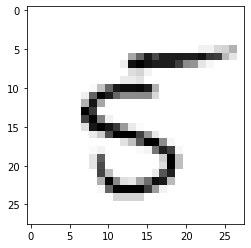

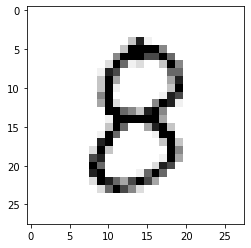

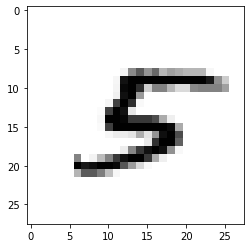

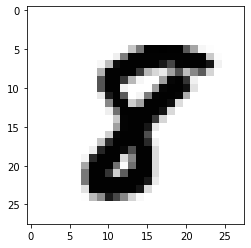

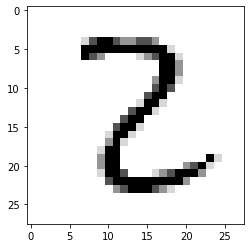

In [5]:
# we will use this function to print images generated by our network
# the parameter images must be a tensor of shape (n images, 784)
def display_images(images):
    # convert to numpy tensor
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
# display the 5 first image in the dataset
display_images(train_data_pixels[:5].cpu())

Then we would like to impose a prior distribution of latent variable $z$, which is a 2D swiss roll. The labels of digits are mapped in a numeric order (i.e., the first 10% of swiss roll is assigned to digit 0 and so on).

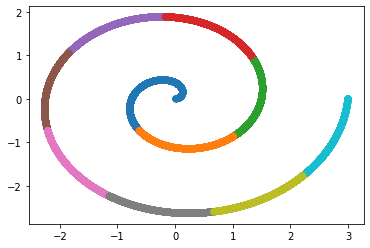

In [6]:
# function to sample batch_size samples in n_dim diminsion that follow a swiss roll distribution (the distribution is even nomatter the sampling size)
def swiss_roll(batch_size, n_labels, n_dim, label_indices=None):
    np.random.seed(0)
    if n_dim != 2:
        raise Exception("n_dim must be 2.")

    def sample(label, n_labels):
        uni = np.random.uniform(0.0, 1.0) / float(n_labels) + float(label) / float(n_labels)
        r = math.sqrt(uni) * 3.0
        rad = np.pi * 4.0 * math.sqrt(uni)
        x = r * math.cos(rad)
        y = r * math.sin(rad)
        return np.array([x, y]).reshape((2,))

    z = np.zeros((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range((int)(n_dim/2)):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(np.random.randint(0, n_labels), n_labels)
    return z


def test(dist_dataset):
    data = []
    labels = []

    for i in range(len(dist_dataset)):
        a, b = dist_dataset[i]
        data.append(a)
        labels.append(b)

    data = np.array(data)
    labels = np.array(labels)
    plt.scatter(data[:, 0], data[:, 1], c=matplotlib.cm.get_cmap("tab10")(train_data_classes.cpu() / 10.))
    plt.show()


points = swiss_roll(train_data_pixels.cpu().shape[0], n_labels = 10, n_dim = 2, label_indices=train_data_classes.cpu())
dist_dataset = list(zip(points, np.array(train_data_classes.cpu())))

test(dist_dataset)

## 1. Construction of Networks

The goal of this part is to learn an Variational Auto-Encoder whose latent space in the form of a swiss roll. Unfortunatelly, in this case we don’t know how to compute the KL term in the loss. To bypass this issue, we replace this term with an adversarial network that will basically learn if a given point is from the prior distribution (the “swiss roll distribution”) or not.

The adversarial network take as input either a point from the swiss roll generate with the code above or a point sampled from the decoder. You must train this adversarial network as a binary classifier with the binary_cross_entropy_with_logits loss from Pytorch:

if the input comes from the swiss roll, the label is 1
if the input comes the encoder, the label is 0
The auto-encoder is trained with the reconstruction loss and a signal coming from the adversarial network that replaces the KL divergence. The idea is that you will give to the advesarial network the sample, and use the binary_cross_entropy_with_logits with the label 1. Howeve, when using this label 1, in this case, you don’t update the adversarial network parameters: the goal is to get a gradient information for the encoder so that its sample “looks like” what is expected, i.e. comes from the prior. Because of the loss used to train the adversarial network (explained just before), this should work.



In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),     # batch norm to prevent internal covariate shift in deeper layer
            nn.ReLU(),

            nn.Linear(hidden_dim,output_dim),
        )

    def forward(self, batch):
        z = self.model(batch)
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh(),
        )

    def forward(self,z):
        return self.model(z)


    def sample_distributions(self, n_samples):
        z = torch.zeros(n_samples, self.input_dim)
        z = z + swiss_roll(n_samples, n_labels=10, n_dim=self.input_dim)
        return self(z)
        

    def sample_images(self, n_samples):
        probs = self.sample_distributions(n_samples)
        return probs

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, batch):
        
        return self.model(batch)   

## 2. Training loop

In [20]:
input_dim = 28*28
latent_dim = 2 # we use only 2 dimensions so we can plot them!
hidden_dim = 512
n_epochs = 30
batch_size = 64


encoder = Encoder(input_dim, hidden_dim, latent_dim).to('cuda')
decoder = Decoder(latent_dim, hidden_dim, input_dim).to('cuda')
discriminator = Discriminator(latent_dim).to('cuda')

In [21]:
encoder_optim = torch.optim.Adam(encoder.parameters(), lr=0.001)
decoder_optim = torch.optim.Adam(decoder.parameters(), lr=0.001)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [22]:
dist_dataset = swiss_roll(train_data_pixels.shape[0], n_labels = 10, n_dim = 2, label_indices=train_data_classes)   # sample our data distribution with digits labels, but these labels will not be used during training process

adversarial_losses = list()
divergence_losses = list()
reconstruction_losses = list()

for epoch in range(n_epochs):
    print("\r%i / %i" % (epoch+1, n_epochs), end="")
    
    # optional: here you can shuffle the dataset
    
    # loop over "batches"
    for i in range(0, train_data_pixels.shape[0], batch_size):    
        # get the batch data
        batch = train_data_pixels[i:i+batch_size]

        # adversarial network update
        # here you must do one update of the adversarial network
        # 1. get a random subset of the swiss roll points (size of the subset must be batch_size)
        # 2. get a random subset from the encoder latent space: you can do that by passing the images in batch to the encoder + the reparam trick
        #    note that we won't need the grad wrt the encoder here, so you can put this computation in a "with torch.no_grad()" block (only this, not the rest!)
        # 3. compute the loss, where values from the swiss roll are labeled as 1 and values from the encoder as 0
        discriminator_optim.zero_grad()

        # BEGIN TODO 
        samples_indice = np.random.choice(len(dist_dataset), batch.shape[0])
        z_real = torch.from_numpy(dist_dataset[samples_indice]).float().to('cuda')

        with torch.no_grad():
             z_fake = encoder(batch)   
        ## As we considered, the reparam trick would have no use :(, because we imply a deterministic distribution for our conditional posterior.
        ## Thus the output of encoder is directly a point on the latenct space, instead values of parameters of a certain proposed distribution... 
              
        # binary cross entropy (no need for logits because the last layer of discriminater is alreay a sigmoid()? )
        loss = -torch.mean(torch.log(discriminator(z_real) + 1e-8) + torch.log(1 - discriminator(z_fake) + 1e-8))
        # END TODO


        loss.backward()
        adversarial_losses.append(loss.item())
        # optional, probably better to try without first
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 5)
        discriminator_optim.step()
        
        # end adversarial network update

        
        # encoder update with the adversarial loss
        # now here, we are going to update only the encoder
        # so that's its latent space looks like a swiss roll
        for _ in range(1): # you can try less (even 1) or more updates here
            encoder_optim.zero_grad()


            # what you need to do here is pass the batch through the encoder and apply the reparam trick.
            # next, you pass this latent code to the adversarial network
            # the idea is that we want the latent space to look like the swiss roll,
            # and the adversarial network knows how the swiss roll looks like!
            # so you build a binary cross entropy loss with label one.
            # You will get a gradient that will "move" the encoder latent space toward a swiss roll

            # BEGIN TODO
            z_fake = encoder(batch)

            dis_z_fake = discriminator(z_fake)

            loss = -torch.mean(torch.log(dis_z_fake + 1e-8))

            # END TODO

            loss.backward()
            divergence_losses.append(loss.item())
            # optional, probably better to try without first
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
            encoder_optim.step()
        
        # end encoder update


        # begin auto-encoder reconstruction loss
        # you should know how to do this...
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()
        
        # BEGIN TODO
        reconstruction_logits = decoder(encoder(batch))
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="mean"
        )
        # END TODO

    
        reconstruction_losses.append(reconstruction_loss.item())

        loss = reconstruction_loss
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        encoder_optim.step()
        decoder_optim.step()
        # end auto-encoder update

        
    # print the reconstruction loss of every last batch of epoch
    print(":\t \t",reconstruction_loss.item())

1 / 30:	 	 0.42813143134117126
2 / 30:	 	 0.40738803148269653
3 / 30:	 	 0.40278688073158264
4 / 30:	 	 0.4029350280761719
5 / 30:	 	 0.40907812118530273
6 / 30:	 	 0.4169303774833679
7 / 30:	 	 0.41668397188186646
8 / 30:	 	 0.41876086592674255
9 / 30:	 	 0.4172356128692627
10 / 30:	 	 0.41659584641456604
11 / 30:	 	 0.41661903262138367
12 / 30:	 	 0.41488340497016907
13 / 30:	 	 0.4149704575538635
14 / 30:	 	 0.4156803786754608
15 / 30:	 	 0.41464170813560486
16 / 30:	 	 0.41371044516563416
17 / 30:	 	 0.4136340320110321
18 / 30:	 	 0.4134369492530823
19 / 30:	 	 0.4132431745529175
20 / 30:	 	 0.41284579038619995
21 / 30:	 	 0.41348686814308167
22 / 30:	 	 0.4131229817867279
23 / 30:	 	 0.41151854395866394
24 / 30:	 	 0.4116632044315338
25 / 30:	 	 0.4121323227882385
26 / 30:	 	 0.4110364317893982
27 / 30:	 	 0.41034382581710815
28 / 30:	 	 0.41071781516075134
29 / 30:	 	 0.41237887740135193
30 / 30:	 	 0.4101174771785736


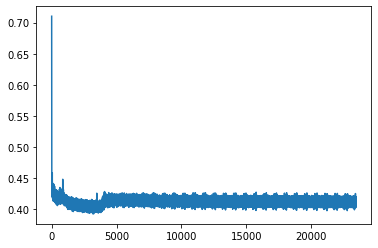

In [31]:
plt.plot(np.arange(len(reconstruction_losses)), reconstruction_losses)
plt.show()

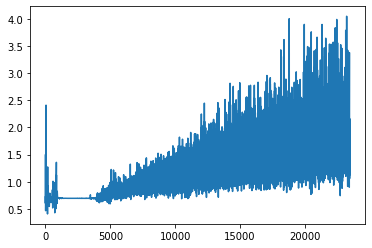

In [32]:
plt.plot(np.arange(len(divergence_losses)), divergence_losses)
plt.show()

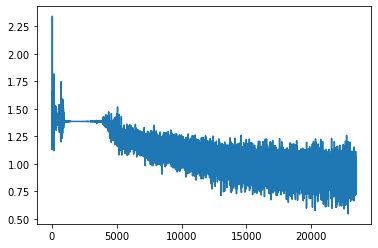

In [33]:
plt.plot(np.arange(len(adversarial_losses[:])), adversarial_losses[:])
plt.show()

## 3. Evaluation

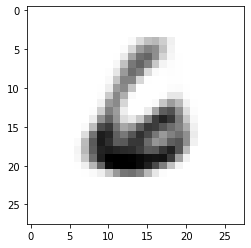

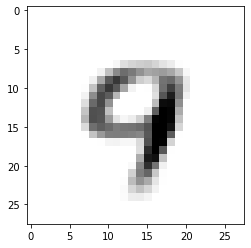

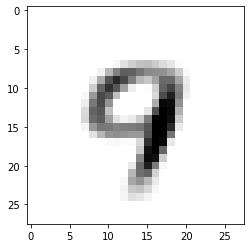

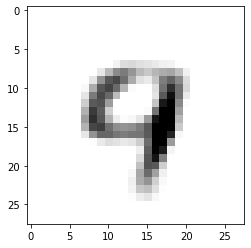

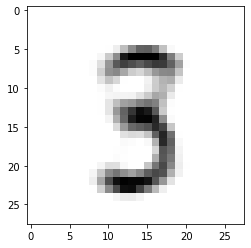

In [34]:
# to generate some samples from the swiss roll prior 
decoder.eval()

with torch.no_grad():

    samples = decoder.cpu().sample_distributions(5)
    display_images(samples)
    plt.show()

In [35]:
# visulization of latent space
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_size): 
        batch = train_data_pixels[i:i+batch_size]
        z = encoder(batch)
        points[i:i+batch.shape[0]] = z.cpu()

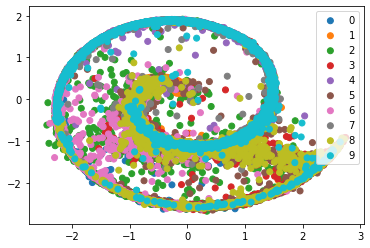

In [39]:
colors = matplotlib.cm.get_cmap("tab10")(train_data_classes.cpu() / 10.)

for i in np.unique(train_data_classes.cpu()):
    scatter = plt.scatter(
        points[train_data_classes.cpu()==i,0], 
        points[train_data_classes.cpu()==i,1],
        c=colors[train_data_classes.cpu()==i],
        label = i
    )
plt.legend(loc='upper right')
plt.savefig('./swiss_roll.png')

In [37]:
# sample uniformly 225 points from swiss roll manifold in order
size = 225
rolling_points = torch.from_numpy(swiss_roll(size, n_labels = size, n_dim = 2, label_indices=range(size))).float()

X = decoder(rolling_points).detach().numpy()
X = X.reshape(-1, 28, 28)

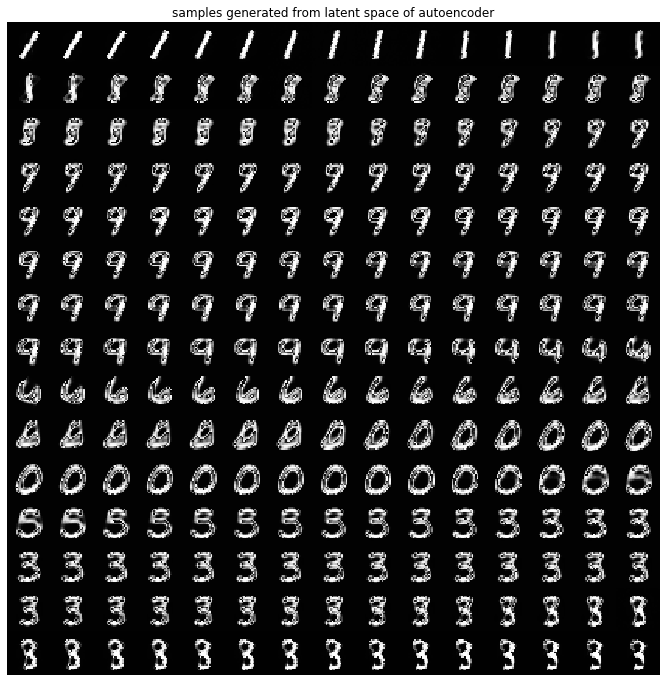

In [40]:
# visulization of generation

# arranged by 15 rows and 15 colomns
N=15; M=15
fig = plt.figure(1, (12., 12.))
ax1 = plt.axes(frameon=False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.title('samples generated from latent space of autoencoder')
im_buf = np.zeros((N*28, M*28), dtype=np.uint8)
for i, x in enumerate(X):
    img = (x * 255).astype(np.uint8)
    n = i//M
    m = i%M
    im_buf[n*28:(n+1)*28, m*28:(m+1)*28] = img

plt.imshow(im_buf, cmap='Greys_r')
# plt.show()
plt.savefig('./samples_generated_from_latent_space_of_autoencoder.png')